In [58]:
import pandas as pd

# Load the dataset
file_path = 'Balaji Fast Food Sales.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,order_id,date,item_name,item_type,item_price,quantity,transaction_amount,transaction_type,received_by,time_of_sale
0,1,07-03-2022,Aalopuri,Fastfood,20,13,260,NaN,Mr.,Night
1,2,8/23/2022,Vadapav,Fastfood,20,15,300,Cash,Mr.,Afternoon
2,3,11/20/2022,Vadapav,Fastfood,20,1,20,Cash,Mr.,Afternoon
3,4,02-03-2023,Sugarcane juice,Beverages,25,6,150,Online,Mr.,Night
4,5,10-02-2022,Sugarcane juice,Beverages,25,8,200,Online,Mr.,Evening


# Data Overview

The dataset contains the following columns:<br>

- order_id: Unique identifier for each order.<br>
- date: Date of the transaction.<br>
- item_name: Name of the food or beverage item.<br>
- item_type: Category of item (Fastfood or Beverages).<br>
- item_price: Price of the item for one quantity.<br>
- quantity: Quantity of the item ordered.<br>
- transaction_amount: Total amount paid by customers.<br>
- transaction_type: Payment method (cash, online, others).<br>
- received_by: Gender of the staff member handling the transaction.<br>
- time_of_sale: Time of the day when the sale occurred (Morning, Evening, Afternoon, Night, Midnight).<br>

Initial Observations
- The date format is inconsistent and needs to be standardized.<br>
- Some transaction types are missing.<br>

## Step 1: Data Cleaning

In [59]:
# Standardize date format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Check for missing values
missing_values = data.isnull().sum()

# Display missing values
missing_values


order_id                0
date                  597
item_name               0
item_type               0
item_price              0
quantity                0
transaction_amount      0
transaction_type      107
received_by             0
time_of_sale            0
dtype: int64

## Step 2: Exploratory Data Analysis (EDA)

In [60]:
# Generate descriptive statistics
data.describe(include='all')

# Group data by relevant columns for analysis
sales_over_time = data.groupby('date')['transaction_amount'].sum().reset_index()
item_sales = data.groupby('item_name')['quantity'].sum().reset_index()
payment_methods = data.groupby('transaction_type')['transaction_amount'].sum().reset_index()
staff_performance = data.groupby('received_by')['transaction_amount'].sum().reset_index()
time_of_sale_popularity = data.groupby(['time_of_sale', 'item_name'])['quantity'].sum().unstack().fillna(0)

# Display data for analysis
sales_over_time.head()
item_sales.head()
payment_methods.head()
staff_performance.head()
time_of_sale_popularity.head()

item_name,Aalopuri,Cold coffee,Frankie,Panipuri,Sandwich,Sugarcane juice,Vadapav
time_of_sale,,,,,,,
Afternoon,226,337,238,230,164,325,194
Evening,136,235,240,241,206,283,199
Midnight,223,203,198,278,201,237,235
Morning,215,287,204,233,234,206,195
Night,244,299,270,244,292,227,183


## Step 3: Data Visualization

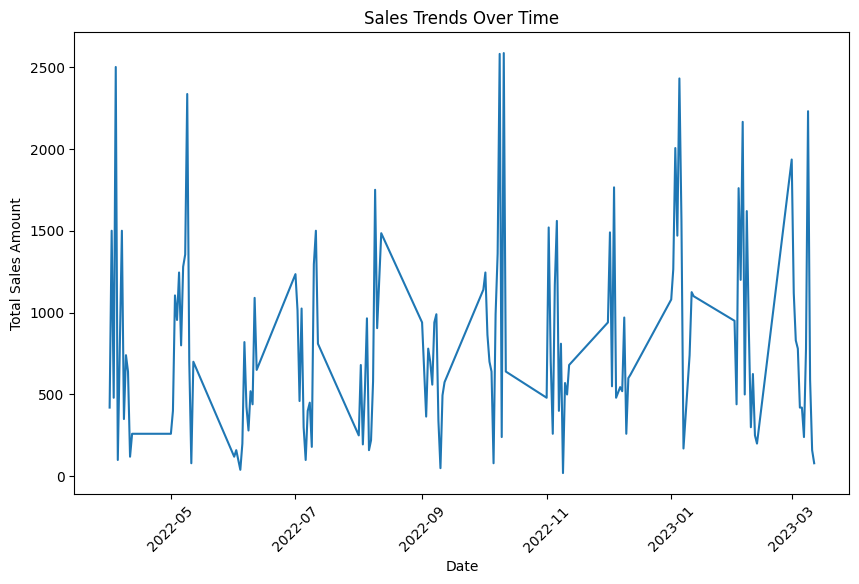

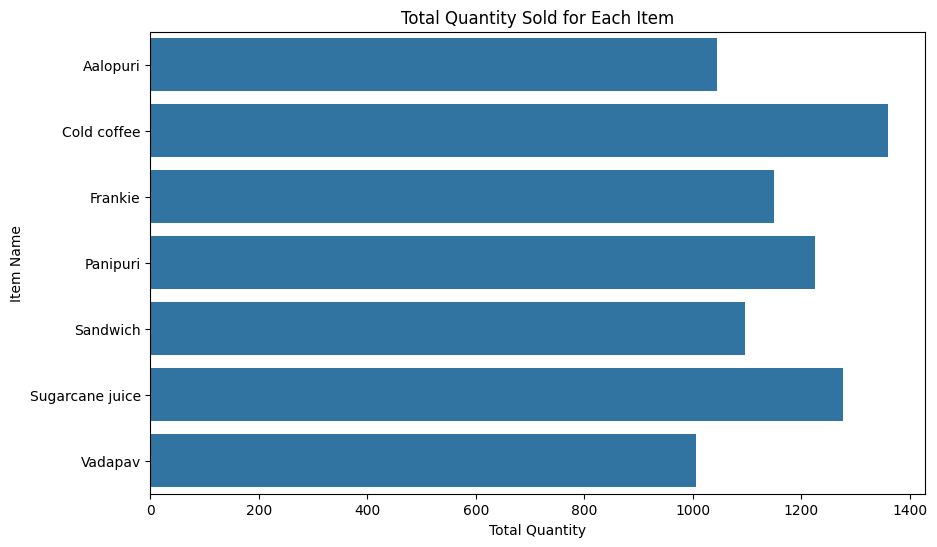

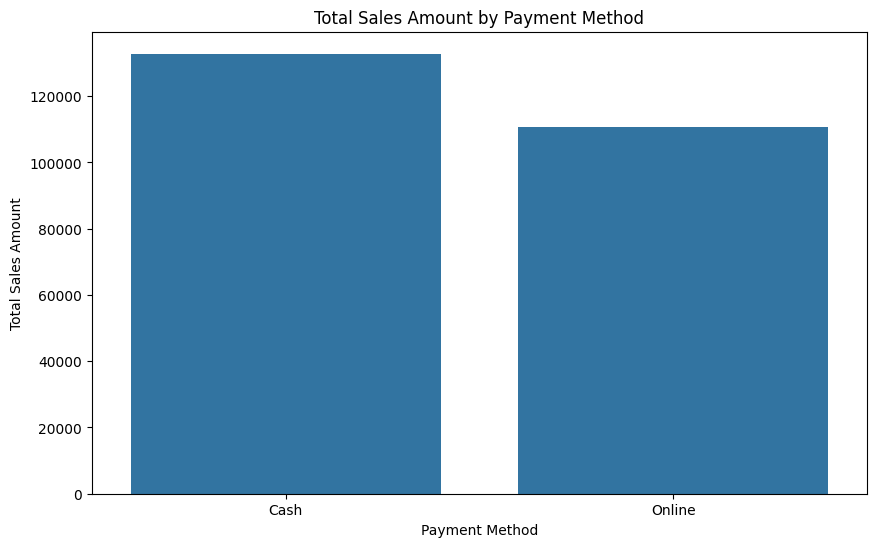

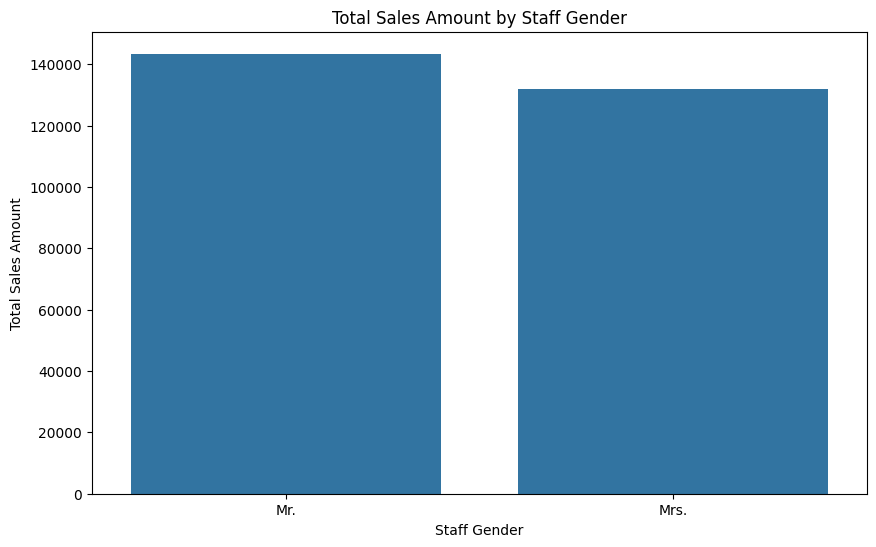

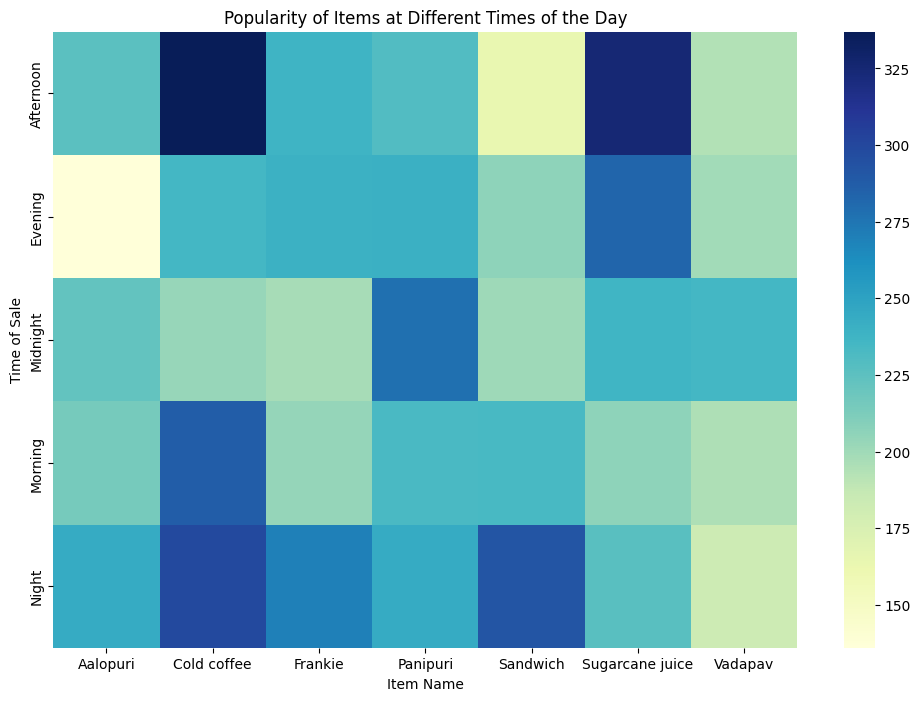

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sales Trends Over Time
plt.figure(figsize=(10, 6))
sns.lineplot(data=sales_over_time, x='date', y='transaction_amount')
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.show()

# Customer Preferences for Different Items
plt.figure(figsize=(10, 6))
sns.barplot(data=item_sales, x='quantity', y='item_name')
plt.title('Total Quantity Sold for Each Item')
plt.xlabel('Total Quantity')
plt.ylabel('Item Name')
plt.show()

# Impact of Payment Methods on Revenue
plt.figure(figsize=(10, 6))
sns.barplot(data=payment_methods, x='transaction_type', y='transaction_amount')
plt.title('Total Sales Amount by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total Sales Amount')
plt.show()

# Performance of Staff Members Based on Gender
plt.figure(figsize=(10, 6))
sns.barplot(data=staff_performance, x='received_by', y='transaction_amount')
plt.title('Total Sales Amount by Staff Gender')
plt.xlabel('Staff Gender')
plt.ylabel('Total Sales Amount')
plt.show()

# Popularity of Items at Different Times of the Day
plt.figure(figsize=(12, 8))
sns.heatmap(time_of_sale_popularity, cmap='YlGnBu')
plt.title('Popularity of Items at Different Times of the Day')
plt.xlabel('Item Name')
plt.ylabel('Time of Sale')
plt.show()


# Sales Trends Over Time

### Draft

In [62]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from dash import dcc, html, Dash
from dash.dependencies import Input, Output
import dash_table

# Load the dataset
file_path = 'Balaji Fast Food Sales.csv'
sales_over_time = pd.read_csv(file_path)

# Ensure sales_over_time['date'] is in datetime format
def parse_date(date_str):
    for fmt in ('%Y-%m-%d', '%m/%d/%Y', '%d-%m-%Y'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    return pd.to_datetime(date_str, errors='coerce')

sales_over_time['date'] = sales_over_time['date'].apply(parse_date)

# Drop rows with invalid dates
sales_over_time = sales_over_time.dropna(subset=['date'])

# Extract month and year for filtering
sales_over_time['year_month'] = sales_over_time['date'].dt.to_period('M').astype(str)

# Group data by payment method
payment_method_revenue = sales_over_time.groupby('transaction_type').agg({
    'transaction_amount': 'sum'
}).reset_index()

# Create the Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1('Impact of Payment Methods on Revenue'),

    html.Label('Filter by Month'),
    dcc.Dropdown(
        id='month-filter',
        options=[{'label': 'All the time', 'value': 'All'}] + [{'label': month, 'value': month} for month in sales_over_time['year_month'].unique()],
        value='All',
        clearable=False,
        style={'width': '200px', 'margin-bottom': '10px'}
    ),

    dcc.Graph(id='treemap-chart'),

    dash_table.DataTable(
        id='data-table',
        columns=[{"name": i, "id": i} for i in payment_method_revenue.columns],
        page_size=10,
        style_table={'height': '400px', 'overflowY': 'auto'},
        style_cell={'textAlign': 'left', 'padding': '5px'},
        style_header={'backgroundColor': 'rgb(230, 230, 230)', 'fontWeight': 'bold'}
    )
])

@app.callback(
    [Output('treemap-chart', 'figure'),
     Output('data-table', 'data')],
    [Input('month-filter', 'value')]
)
def update_chart(month):
    filtered_data = sales_over_time.copy()

    if month != 'All':
        filtered_data = filtered_data[filtered_data['year_month'] == month]

    # Group filtered data by payment method
    grouped_data = filtered_data.groupby('transaction_type').agg({
        'transaction_amount': 'sum'
    }).reset_index()

    # Create the interactive treemap chart
    fig = px.treemap(
        grouped_data,
        path=['transaction_type'],
        values='transaction_amount',
        color='transaction_amount',
        hover_data={'transaction_type': True, 'transaction_amount': True},
        labels={'transaction_type': 'Payment Method', 'transaction_amount': 'Total Revenue'},
        title='Impact of Payment Methods on Revenue'
    )

    # Customize the chart's appearance
    fig.update_layout(
        template='plotly_white',
        title_font=dict(size=24, family='Arial', color='black'),
        font=dict(family='Arial', size=14, color='black')
    )

    return fig, grouped_data.to_dict('records')

if __name__ == '__main__':
    app.run_server(debug=True)


In [63]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the dataset 
file_path = 'Balaji Fast Food Sales.csv'
sales_over_time = pd.read_csv(file_path)

# Ensure sales_over_time['date'] is in datetime format
sales_over_time['date'] = pd.to_datetime(sales_over_time['date'], errors='coerce')

# Group data by item name and item type
item_sales = sales_over_time.groupby(['item_name', 'item_type']).agg({
    'quantity': 'sum'
}).reset_index()

# Create the interactive bar chart
fig = px.bar(
    item_sales,
    x='item_name',
    y='quantity',
    color='item_type',
    hover_data={'item_name': True, 'quantity': True},
    labels={'item_name': 'Item Name', 'quantity': 'Quantity Sold'},
    title='Customer Preferences for Different Items',
    category_orders={'item_type': ['Fastfood', 'Beverages']}
)

# Customize the chart's appearance
fig.update_layout(
    template='plotly_white',
    title_font=dict(size=24, family='Arial', color='black'),
    xaxis_title='Item Name',
    yaxis_title='Quantity Sold',
    legend_title='Item Type',
    font=dict(family='Arial', size=14, color='black')
)

# Enable interactive sorting by item name or quantity sold
fig.update_traces(
    marker=dict(line=dict(width=1, color='black')),
    hovertemplate='<b>Item Name:</b> %{x}<br><b>Quantity Sold:</b> %{y}<extra></extra>'
)

# Add data filtering for item type
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(label='All',
                     method='update',
                     args=[{'visible': [True] * len(item_sales)}]),
                dict(label='Fastfood',
                     method='update',
                     args=[{'visible': item_sales['item_type'] == 'Fastfood'}]),
                dict(label='Beverages',
                     method='update',
                     args=[{'visible': item_sales['item_type'] == 'Beverages'}]),
            ]),
            direction='down',
            pad={'r': 10, 't': 10},
            showactive=True,
        )
    ]
)

# Show the plot
fig.show()


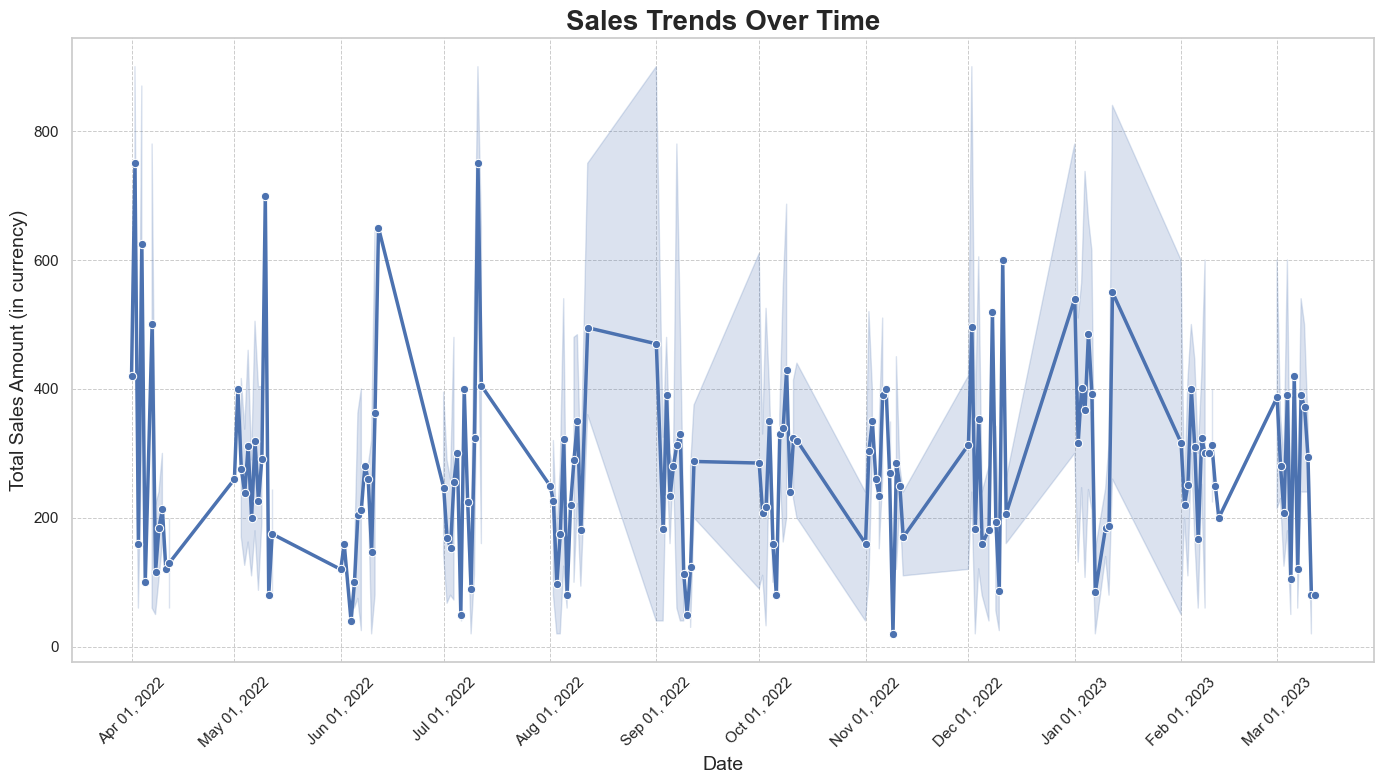

In [64]:
import matplotlib.dates as mdates

# Sales Trends Over Time (Enhanced)
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Plotting the sales trends
sns.lineplot(data=sales_over_time, x='date', y='transaction_amount', marker='o', color='b', linewidth=2.5)

# Enhancing the plot
plt.title('Sales Trends Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales Amount (in currency)', fontsize=14)

# Formatting the x-axis for better readability
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Adding a grid
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7)

# Highlighting key dates (optional, example annotations)
max_date = sales_over_time.loc[sales_over_time['transaction_amount'].idxmax()]['date']
max_amount = sales_over_time['transaction_amount'].max()

plt.annotate(f'Highest Sales: {max_amount}',
             xy=(max_date, max_amount),
             xytext=(max_date, max_amount + 500),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12,
             fontweight='bold')

plt.tight_layout()
plt.show()


1. Add Color Coding: Differentiate data points or lines using colors to highlight specific periods, such as seasons, holidays, or weekends.
2. Smoothed Line: Consider adding a smoothed trend line to show the overall trend more clearly, alongside the existing data points.
3. Annotations: Add more annotations for key events, promotions, or holidays that might have impacted sales.
4. Legend: Include a legend if you add multiple lines or trend indicators.
5. Interactivity: If presenting this in a digital format (e.g., a dashboard), make it interactive so viewers can hover over points to see details.
6. Secondary Axis: If there are any secondary metrics (like number of transactions), consider adding a secondary y-axis to show the relationship between sales amount and other variables.

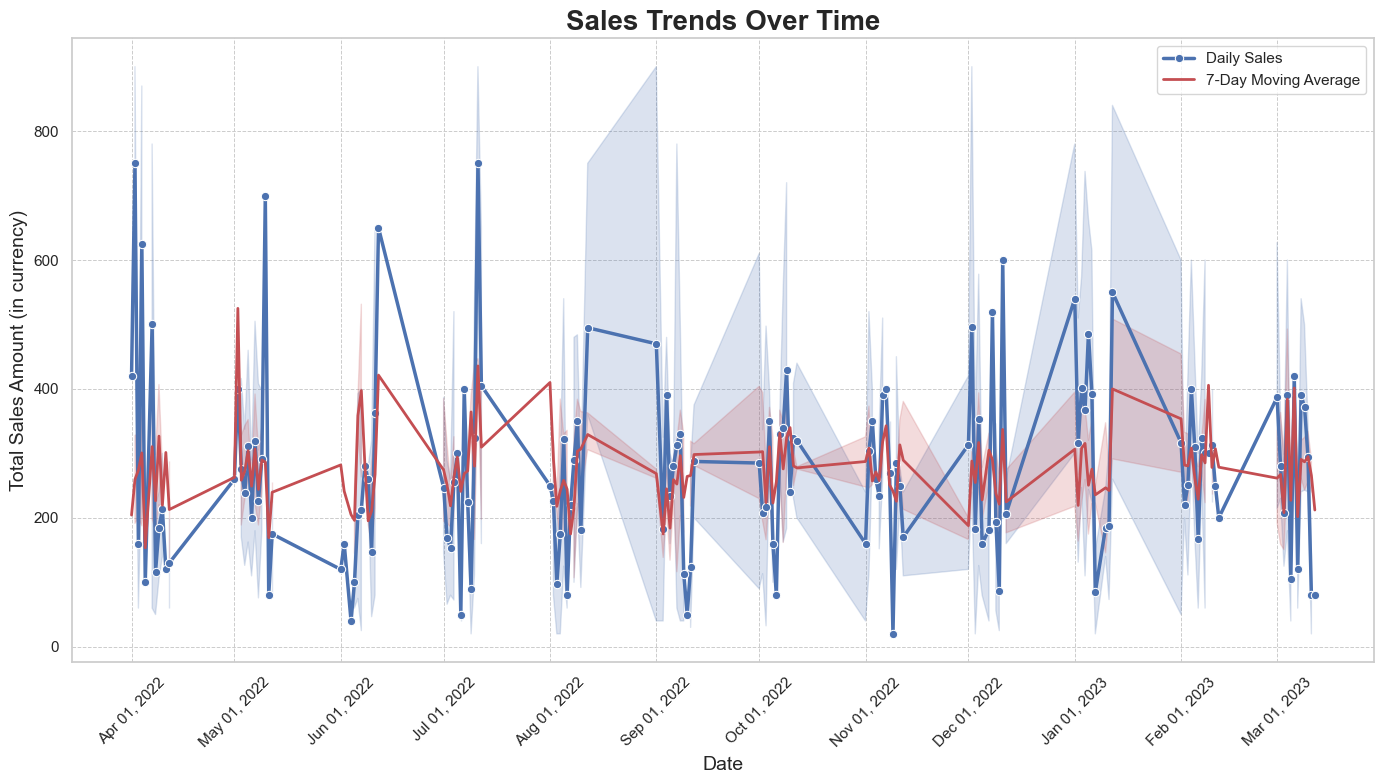

In [65]:
import matplotlib.dates as mdates
import numpy as np

# Create a smoothed trend line using a rolling window
sales_over_time['smoothed'] = sales_over_time['transaction_amount'].rolling(window=7).mean()

# Sales Trends Over Time (Enhanced)
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Plotting the sales trends
sns.lineplot(data=sales_over_time, x='date', y='transaction_amount', marker='o', color='b', linewidth=2.5, label='Daily Sales')
sns.lineplot(data=sales_over_time, x='date', y='smoothed', color='r', linewidth=2, label='7-Day Moving Average')

# Enhancing the plot
plt.title('Sales Trends Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales Amount (in currency)', fontsize=14)

# Formatting the x-axis for better readability
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Adding a grid
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7)

# Highlighting key dates (optional, example annotations)
max_date = sales_over_time.loc[sales_over_time['transaction_amount'].idxmax()]['date']
max_amount = sales_over_time['transaction_amount'].max()

plt.annotate(f'Highest Sales: {max_amount}',
             xy=(max_date, max_amount),
             xytext=(max_date, max_amount + 500),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12,
             fontweight='bold')

# Adding a legend
plt.legend()

plt.tight_layout()
plt.show()


1. Add Vertical Lines for Major Events: If there are any known events, promotions, or holidays that could impact sales, add vertical lines to indicate these events.
2. Highlight Weekends: If the data includes weekends, you can shade the weekends to highlight the difference in sales patterns between weekdays and weekends.
3. Enhanced Annotations: Provide more detailed annotations for specific peaks or troughs in the data.
4. Minor Ticks on X-axis: Add minor ticks to the x-axis to improve the granularity of the date labels.

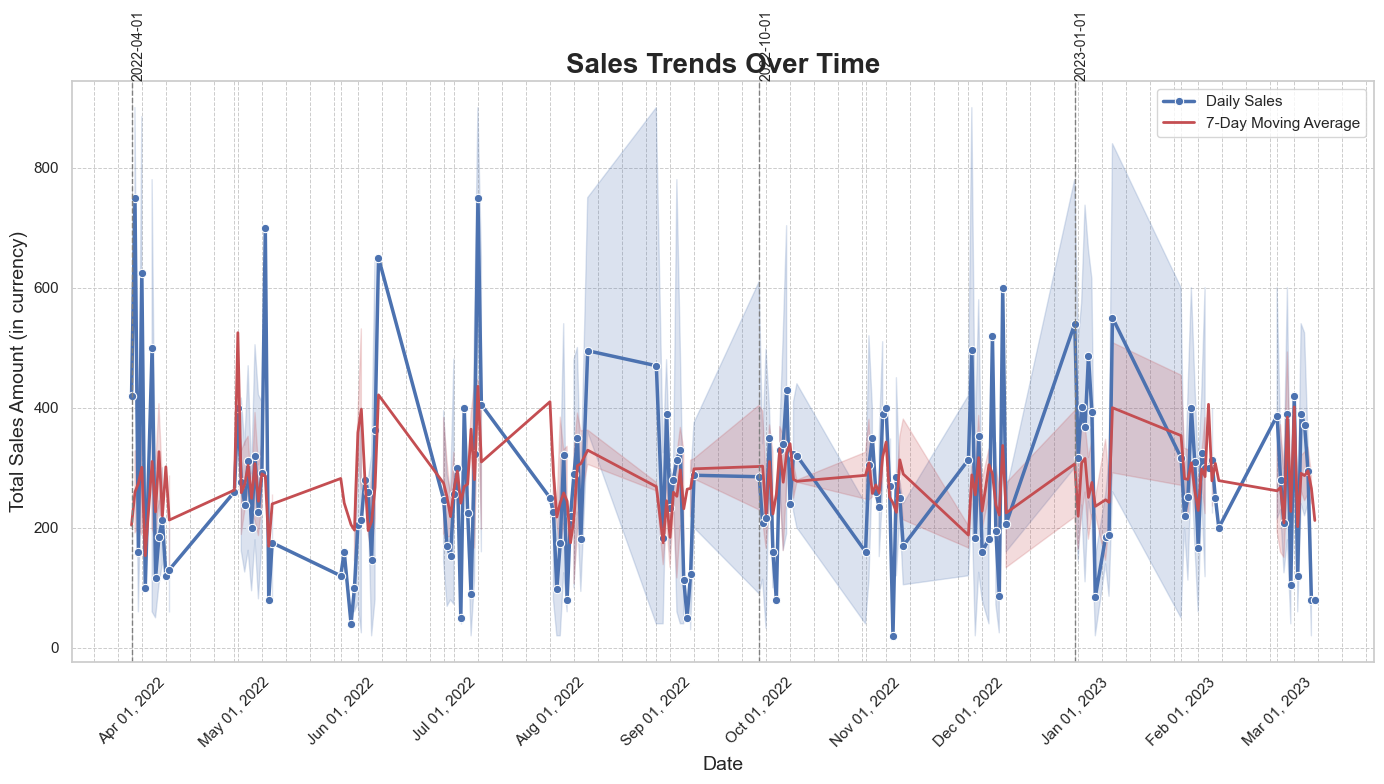

In [66]:
import matplotlib.dates as mdates
import numpy as np

# Create a smoothed trend line using a rolling window
sales_over_time['smoothed'] = sales_over_time['transaction_amount'].rolling(window=7).mean()

# Sales Trends Over Time (Enhanced)
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Plotting the sales trends
sns.lineplot(data=sales_over_time, x='date', y='transaction_amount', marker='o', color='b', linewidth=2.5, label='Daily Sales')
sns.lineplot(data=sales_over_time, x='date', y='smoothed', color='r', linewidth=2, label='7-Day Moving Average')

# Enhancing the plot
plt.title('Sales Trends Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales Amount (in currency)', fontsize=14)

# Formatting the x-axis for better readability
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO))

# Adding a grid
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7)

# Highlighting key dates (example annotations)
max_date = sales_over_time.loc[sales_over_time['transaction_amount'].idxmax()]['date']
max_amount = sales_over_time['transaction_amount'].max()

plt.annotate(f'Highest Sales: {max_amount}',
             xy=(max_date, max_amount),
             xytext=(max_date, max_amount + 500),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12,
             fontweight='bold')

# Adding vertical lines for major events (example)
important_dates = ['2022-04-01', '2022-10-01', '2023-01-01']
for date in important_dates:
    plt.axvline(pd.to_datetime(date), color='grey', linestyle='--', linewidth=1)
    plt.text(pd.to_datetime(date), plt.ylim()[1], date, rotation=90, verticalalignment='bottom', fontsize=10)

# Adding a legend
plt.legend()

plt.tight_layout()
plt.show()


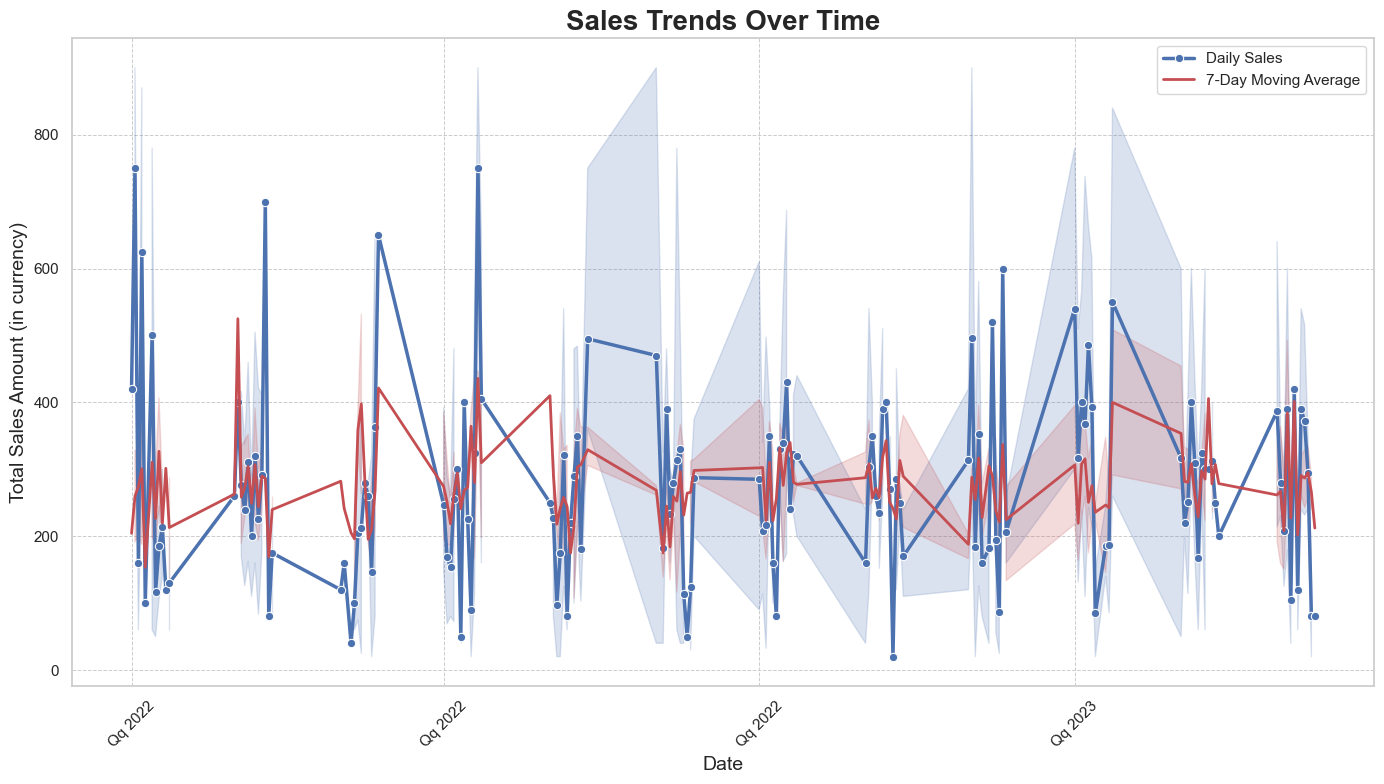

In [67]:
# Import required packages
import matplotlib.dates as mdates

# Create a smoothed trend line using a rolling window
sales_over_time['smoothed'] = sales_over_time['transaction_amount'].rolling(window=7).mean()

# Function to determine the quarter
def get_quarter(date):
    return (date.month-1)//3 + 1

# Add a column for the quarter
sales_over_time['quarter'] = sales_over_time['date'].apply(get_quarter)
sales_over_time['year_quarter'] = sales_over_time['date'].dt.year.astype(str) + ' Q' + sales_over_time['quarter'].astype(str)

# Sales Trends Over Time (Enhanced)
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Plotting the sales trends
sns.lineplot(data=sales_over_time, x='date', y='transaction_amount', marker='o', color='b', linewidth=2.5, label='Daily Sales')
sns.lineplot(data=sales_over_time, x='date', y='smoothed', color='r', linewidth=2, label='7-Day Moving Average')

# Enhancing the plot
plt.title('Sales Trends Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales Amount (in currency)', fontsize=14)

# Formatting the x-axis for better readability, using quarters
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('Q%q %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))

# Adding a grid
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7)

# Highlighting key dates (example annotations)
max_date = sales_over_time.loc[sales_over_time['transaction_amount'].idxmax()]['date']
max_amount = sales_over_time['transaction_amount'].max()

plt.annotate(f'Highest Sales: {max_amount}',
             xy=(max_date, max_amount),
             xytext=(max_date, max_amount + 500),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12,
             fontweight='bold')

# Adding a legend
plt.legend()

plt.tight_layout()
plt.show()



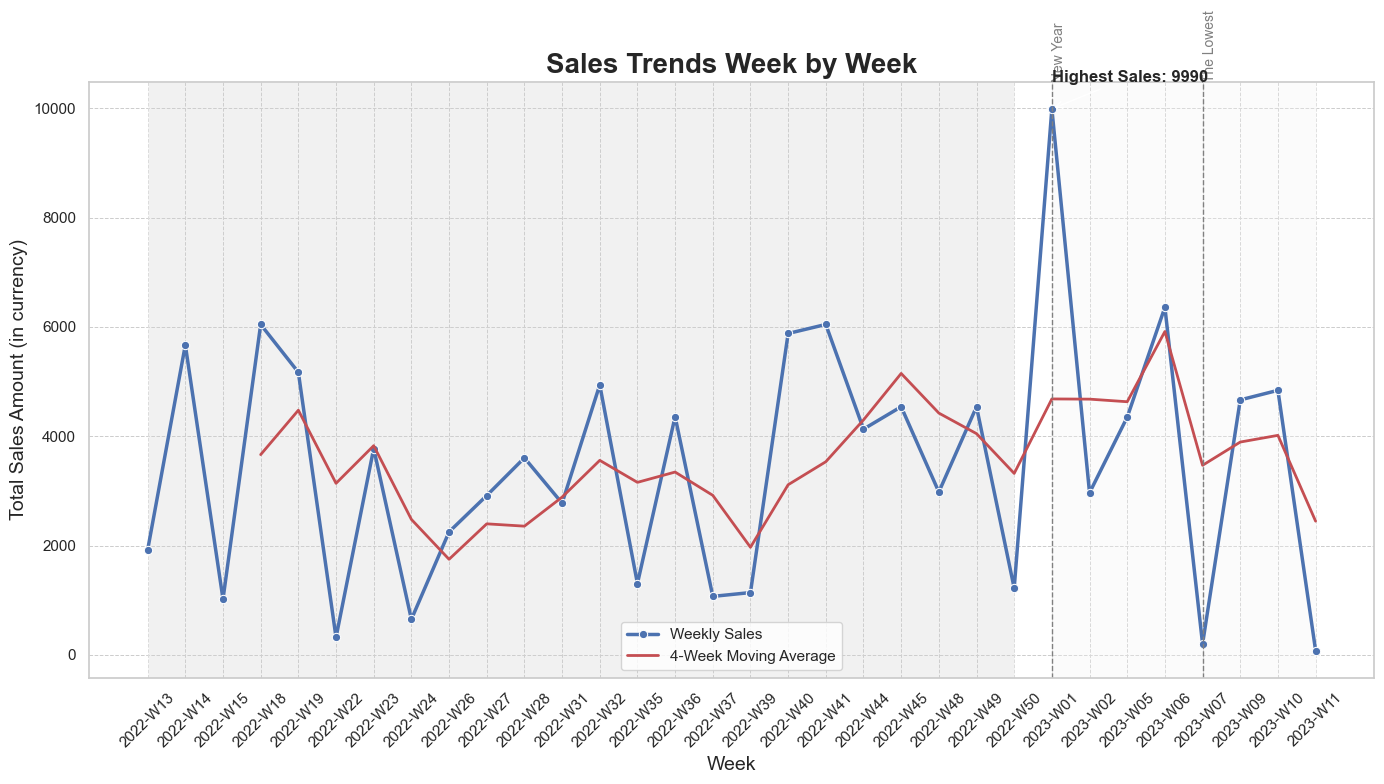

In [68]:
import matplotlib.dates as mdates

# Convert date to week number and year
sales_over_time['week'] = sales_over_time['date'].dt.isocalendar().week
sales_over_time['year'] = sales_over_time['date'].dt.year
sales_over_time['year_week'] = sales_over_time['date'].dt.strftime('%Y-W%U')

# Group data by week
weekly_sales = sales_over_time.groupby('year_week').agg({
    'transaction_amount': 'sum',
    'smoothed': 'sum'
}).reset_index()

# Create a new smoothed trend line using a rolling window
weekly_sales['smoothed'] = weekly_sales['transaction_amount'].rolling(window=4).mean()

# Example: Add major events (e.g., promotions, holidays)
major_events = {
    '2023-W01': 'New Year',
    '2023-W07': 'The Lowest',
    # '2022-W45': 'Event C',
    # '2023-W10': 'Promotion D'
}

# Sales Trends Week by Week (Enhanced)
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Plotting the weekly sales trends
sns.lineplot(data=weekly_sales, x='year_week', y='transaction_amount', marker='o', color='b', linewidth=2.5, label='Weekly Sales')
sns.lineplot(data=weekly_sales, x='year_week', y='smoothed', color='r', linewidth=2, label='4-Week Moving Average')

# Enhancing the plot
plt.title('Sales Trends Week by Week', fontsize=20, fontweight='bold')
plt.xlabel('Week', fontsize=14)
plt.ylabel('Total Sales Amount (in currency)', fontsize=14)

# Formatting the x-axis for better readability
plt.xticks(rotation=45)

# Adding a grid
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7)

# Adding vertical lines for major events
for event_week, event_name in major_events.items():
    plt.axvline(x=event_week, color='grey', linestyle='--', linewidth=1)
    plt.text(event_week, plt.ylim()[1], event_name, rotation=90, verticalalignment='bottom', fontsize=10, color='grey')
    
# Highlighting key weeks (example annotations)
max_week = weekly_sales.loc[weekly_sales['transaction_amount'].idxmax()]['year_week']
max_amount = weekly_sales['transaction_amount'].max()

plt.annotate(f'Highest Sales: {max_amount}',
             xy=(max_week, max_amount),
             xytext=(max_week, max_amount + 500),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12,
             fontweight='bold')

# Adding subtle shading for different years
for i, year in enumerate(weekly_sales['year_week'].str[:4].unique()):
    year_weeks = weekly_sales[weekly_sales['year_week'].str.startswith(year)]
    plt.axvspan(year_weeks['year_week'].min(), year_weeks['year_week'].max(), facecolor=('lightgrey' if i % 2 == 0 else 'whitesmoke'), alpha=0.3)

# Adding a legend
plt.legend()

plt.tight_layout()
plt.show()


### Sales Trends Day by Day

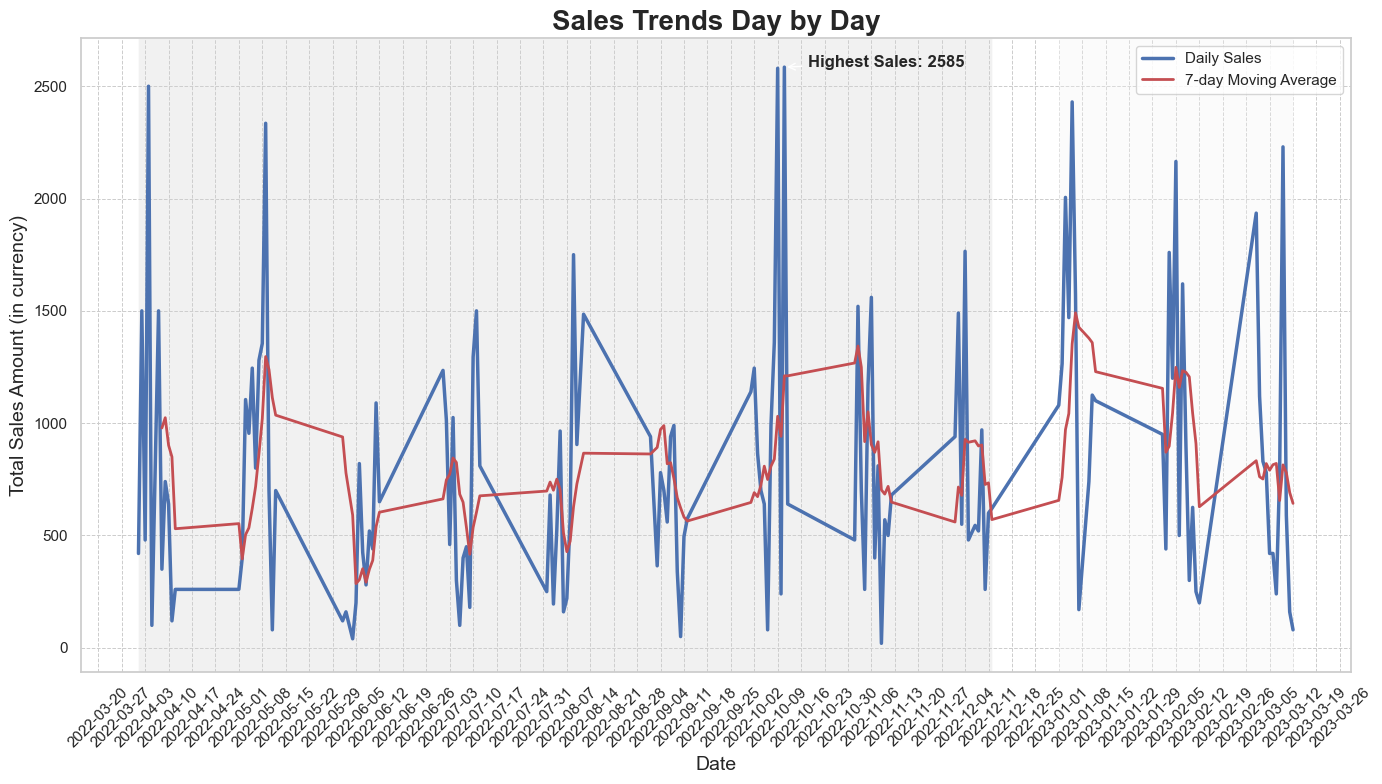

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

# Load the dataset
file_path = 'Balaji Fast Food Sales.csv'
sales_over_time = pd.read_csv(file_path)

# Ensure sales_over_time['date'] is in datetime format
sales_over_time['date'] = pd.to_datetime(sales_over_time['date'], errors='coerce')

# Group data by day
daily_sales = sales_over_time.groupby('date').agg({
    'transaction_amount': 'sum'
}).reset_index()

# Create a new smoothed trend line using a rolling window for 7 days
daily_sales['7day_moving_average'] = daily_sales['transaction_amount'].rolling(window=7).mean()

# Sales Trends Day by Day (Enhanced)
plt.figure(figsize=(14, 8))
plt.plot(daily_sales['date'], daily_sales['transaction_amount'], color='b', linewidth=2.5, label='Daily Sales')
plt.plot(daily_sales['date'], daily_sales['7day_moving_average'], color='r', linewidth=2, label='7-day Moving Average')

# Enhancing the plot
plt.title('Sales Trends Day by Day', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales Amount (in currency)', fontsize=14)

# Formatting the x-axis for better readability
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Show labels every 7 days

# Adding a grid
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7)

# Highlighting key days (example annotations)
max_day = daily_sales.loc[daily_sales['transaction_amount'].idxmax()]['date']
max_amount = daily_sales['transaction_amount'].max()

# Adjusting the position of the highest sales annotation
plt.annotate(f'Highest Sales: {max_amount}',
             xy=(max_day, max_amount),
             xytext=(max_day + pd.DateOffset(days=7), max_amount),  # Move the annotation to the right of the highest point
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12,
             fontweight='bold')

# Adding subtle shading for different years (if applicable)
for i, year in enumerate(daily_sales['date'].dt.year.unique()):
    year_days = daily_sales[daily_sales['date'].dt.year == year]
    plt.axvspan(year_days['date'].min(), year_days['date'].max(), facecolor=('lightgrey' if i % 2 == 0 else 'whitesmoke'), alpha=0.3)

# Adding a legend
plt.legend()

plt.tight_layout()
plt.show()


### Sales Trends Week by Week

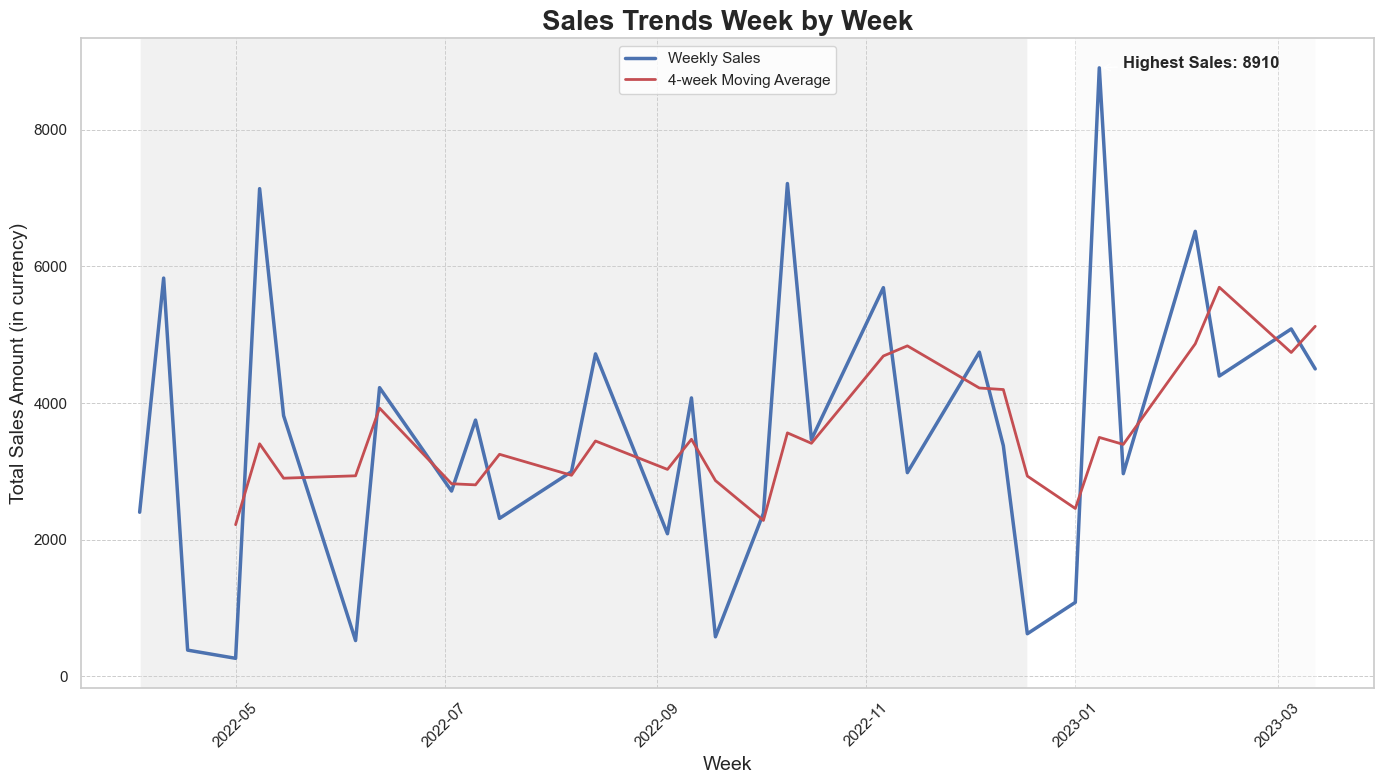

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

# Load the dataset 
file_path = 'Balaji Fast Food Sales.csv'
sales_over_time = pd.read_csv(file_path)

# Ensure sales_over_time['date'] is in datetime format
sales_over_time['date'] = pd.to_datetime(sales_over_time['date'], errors='coerce')

# Convert date to week and year as string
sales_over_time['year_week'] = sales_over_time['date'].dt.strftime('%Y-%W')

# Group data by week
weekly_sales = sales_over_time.groupby('year_week').agg({
    'transaction_amount': 'sum'
}).reset_index()

# Convert 'year_week' back to datetime for plotting
weekly_sales['year_week'] = pd.to_datetime(weekly_sales['year_week'] + '-0', format='%Y-%W-%w')

# Create a new smoothed trend line using a rolling window for weeks (4 weeks)
weekly_sales['4week_moving_average'] = weekly_sales['transaction_amount'].rolling(window=4).mean()

# Sales Trends Week by Week (Enhanced)
plt.figure(figsize=(14, 8))
plt.plot(weekly_sales['year_week'], weekly_sales['transaction_amount'], color='b', linewidth=2.5, label='Weekly Sales')
plt.plot(weekly_sales['year_week'], weekly_sales['4week_moving_average'], color='r', linewidth=2, label='4-week Moving Average')

# Enhancing the plot
plt.title('Sales Trends Week by Week', fontsize=20, fontweight='bold')
plt.xlabel('Week', fontsize=14)
plt.ylabel('Total Sales Amount (in currency)', fontsize=14)

# Formatting the x-axis for better readability
plt.xticks(rotation=45)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%W'))
# plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))

# Adding a grid
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7)

# Highlighting key weeks (example annotations)
max_week = weekly_sales.loc[weekly_sales['transaction_amount'].idxmax()]['year_week']
max_amount = weekly_sales['transaction_amount'].max()

# Adjusting the position of the highest sales annotation
plt.annotate(f'Highest Sales: {max_amount}',
             xy=(max_week, max_amount),
             xytext=(max_week + pd.DateOffset(weeks=1), max_amount),  # Move the annotation to the right of the highest point
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12,
             fontweight='bold')

# Adding subtle shading for different years
for i, year in enumerate(weekly_sales['year_week'].dt.year.unique()):
    year_weeks = weekly_sales[weekly_sales['year_week'].dt.year == year]
    plt.axvspan(year_weeks['year_week'].min(), year_weeks['year_week'].max(), facecolor=('lightgrey' if i % 2 == 0 else 'whitesmoke'), alpha=0.3)

# Adding a legend
plt.legend()

plt.tight_layout()
plt.show()

### Sales Trends Month by Month

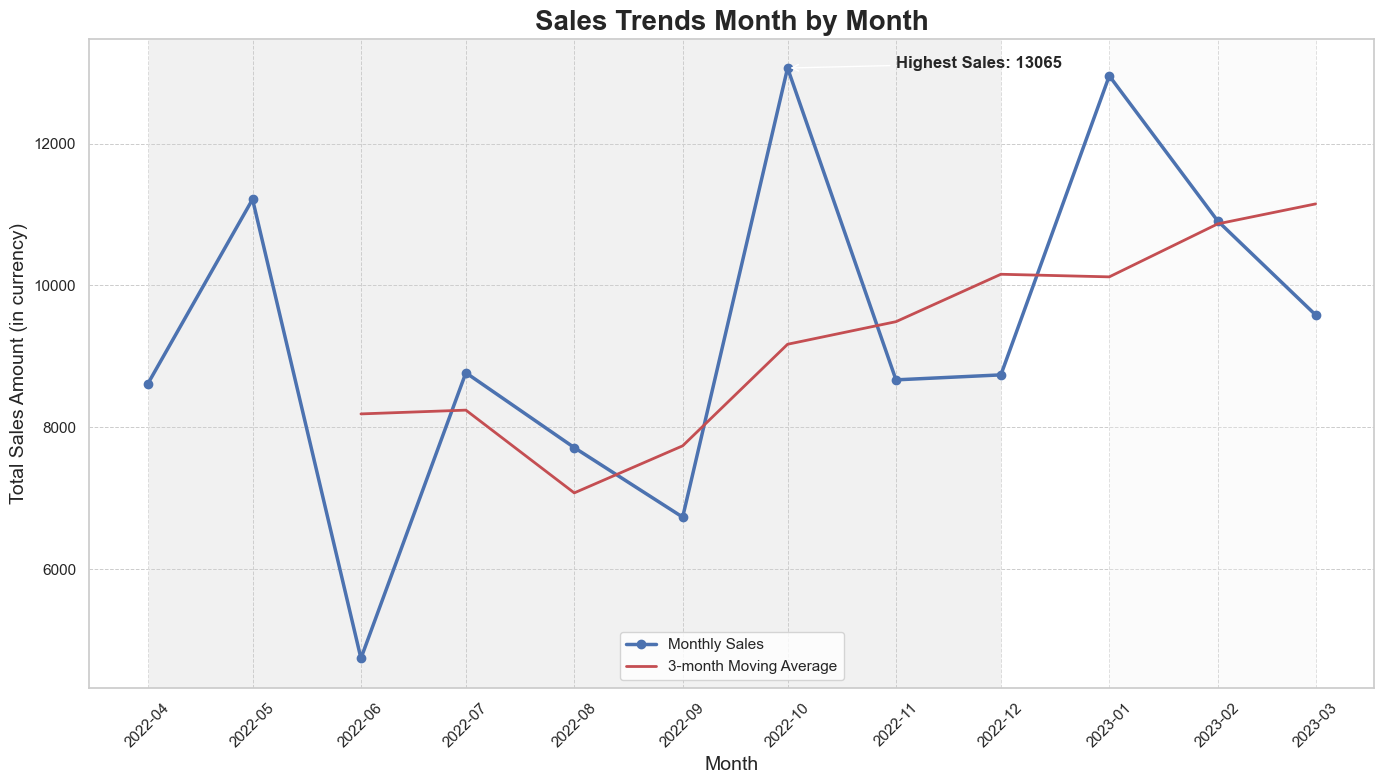

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

# Load the dataset
file_path = 'Balaji Fast Food Sales.csv'
sales_over_time = pd.read_csv(file_path)

# Ensure sales_over_time['date'] is in datetime format
sales_over_time['date'] = pd.to_datetime(sales_over_time['date'], errors='coerce')

# Check for NaT values and remove them
# print(f"Number of NaT values before cleaning: {sales_over_time['date'].isna().sum()}")
sales_over_time = sales_over_time.dropna(subset=['date'])
# print(f"Number of NaT values after cleaning: {sales_over_time['date'].isna().sum()}")

# Convert date to month and year as string
sales_over_time['year_month'] = sales_over_time['date'].dt.to_period('M').astype(str)

# Group data by month
monthly_sales = sales_over_time.groupby('year_month').agg({
    'transaction_amount': 'sum'
}).reset_index()

# Convert 'year_month' back to datetime for plotting
monthly_sales['year_month'] = pd.to_datetime(monthly_sales['year_month'], format='%Y-%m')

# Create a new smoothed trend line using a rolling window for months (3 months)
monthly_sales['3month_moving_average'] = monthly_sales['transaction_amount'].rolling(window=3).mean()

# Sales Trends Month by Month (Enhanced)
plt.figure(figsize=(14, 8))
plt.plot(monthly_sales['year_month'], monthly_sales['transaction_amount'], marker='o', color='b', linewidth=2.5, label='Monthly Sales')
plt.plot(monthly_sales['year_month'], monthly_sales['3month_moving_average'], color='r', linewidth=2, label='3-month Moving Average')

# Enhancing the plot
plt.title('Sales Trends Month by Month', fontsize=20, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Sales Amount (in currency)', fontsize=14)

# Formatting the x-axis for better readability
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Adding a grid
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7)

# Highlighting key months (example annotations)
max_month = monthly_sales.loc[monthly_sales['transaction_amount'].idxmax()]['year_month']
max_amount = monthly_sales['transaction_amount'].max()

# Adjusting the position of the highest sales annotation
plt.annotate(f'Highest Sales: {max_amount}',
             xy=(max_month, max_amount),
             xytext=(max_month + pd.DateOffset(months=1), max_amount),  # Move the annotation to the right of the highest point
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12,
             fontweight='bold')

# Adding subtle shading for different years
for i, year in enumerate(monthly_sales['year_month'].dt.year.unique()):
    year_months = monthly_sales[monthly_sales['year_month'].dt.year == year]
    plt.axvspan(year_months['year_month'].min(), year_months['year_month'].max(), facecolor=('lightgrey' if i % 2 == 0 else 'whitesmoke'), alpha=0.3)

# Adding a legend
plt.legend()

plt.tight_layout()
plt.show()


### Interactive

In [72]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the dataset
file_path = 'Balaji Fast Food Sales.csv'
sales_over_time = pd.read_csv(file_path)

# Ensure sales_over_time['date'] is in datetime format
sales_over_time['date'] = pd.to_datetime(sales_over_time['date'], errors='coerce')

# Group data by day
daily_sales = sales_over_time.groupby('date').agg({
    'transaction_amount': 'sum'
}).reset_index()

# Create a new smoothed trend line using a rolling window for days (7 days)
daily_sales['7day_moving_average'] = daily_sales['transaction_amount'].rolling(window=7).mean()

# Calculate IQR for transaction amounts
Q1 = daily_sales['transaction_amount'].quantile(0.25)
Q3 = daily_sales['transaction_amount'].quantile(0.75)
IQR = Q3 - Q1

# Determine y-axis range based on IQR
y_min = Q1 - 1.5 * IQR
y_max = 3000

# Create a figure
fig = make_subplots(specs=[[{"secondary_y": False}]])

# Add daily sales trace
fig.add_trace(
    go.Scatter(x=daily_sales['date'], y=daily_sales['transaction_amount'], mode='lines+markers', name='Daily Sales'),
    secondary_y=False,
)

# Add 7-day Moving Average trace
fig.add_trace(
    go.Scatter(x=daily_sales['date'], y=daily_sales['7day_moving_average'], mode='lines', name='7-day Moving Average'),
    secondary_y=False,
)

# Adding the highest sales annotation
max_day = daily_sales.loc[daily_sales['transaction_amount'].idxmax()]['date']
max_amount = daily_sales['transaction_amount'].max()
fig.add_annotation(
    x=max_day,
    y=max_amount,
    text=f"Highest Sales: {max_amount}",
    showarrow=True,
    arrowhead=2,
    ax=20,
    ay=-40
)

# Update layout
fig.update_layout(
    title_text='Sales Trends Day by Day',
    xaxis_title='Day',
    yaxis_title='Total Sales Amount (in currency)',
    legend_title='Legend',
    template='plotly_white',
    xaxis=dict(
        tickmode='array',
        # tickvals=daily_sales['date'],
        # ticktext=daily_sales['date'].dt.strftime('%Y-%m-%d'),
        tickangle=-45  # Rotate tick labels for better readability
    ),
    yaxis=dict(
        range=[y_min, y_max]  # Set y-axis range based on the IQR
    )
)

# Show the plot
fig.show()


In [73]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the dataset
file_path = 'Balaji Fast Food Sales.csv'
sales_over_time = pd.read_csv(file_path)

# Ensure sales_over_time['date'] is in datetime format
sales_over_time['date'] = pd.to_datetime(sales_over_time['date'], errors='coerce')

# Convert date to month and year as string
sales_over_time['year_month'] = sales_over_time['date'].dt.to_period('M').astype(str)

# Group data by month
monthly_sales = sales_over_time.groupby('year_month').agg({
    'transaction_amount': 'sum'
}).reset_index()

# Convert 'year_month' back to datetime for plotting
monthly_sales['year_month'] = pd.to_datetime(monthly_sales['year_month'], format='%Y-%m')

# Create a new smoothed trend line using a rolling window for quarters (3 months)
monthly_sales['3month_moving_average'] = monthly_sales['transaction_amount'].rolling(window=3).mean()

# Calculate IQR for transaction amounts
Q1 = monthly_sales['transaction_amount'].quantile(0.25)
Q3 = monthly_sales['transaction_amount'].quantile(0.75)
IQR = Q3 - Q1

# Determine y-axis range based on IQR
y_min = Q1 - 1.5 * IQR
y_max = Q3 + 1.5 * IQR

# Create a figure
fig = make_subplots(specs=[[{"secondary_y": False}]])

# Add monthly sales trace
fig.add_trace(
    go.Scatter(x=monthly_sales['year_month'], y=monthly_sales['transaction_amount'], mode='lines+markers', name='Monthly Sales'),
    secondary_y=False,
)

# Add 3-month Moving Average trace
fig.add_trace(
    go.Scatter(x=monthly_sales['year_month'], y=monthly_sales['3month_moving_average'], mode='lines', name='3-month Moving Average'),
    secondary_y=False,
)

# Adding the highest sales annotation
max_month = monthly_sales.loc[monthly_sales['transaction_amount'].idxmax()]['year_month']
max_amount = monthly_sales['transaction_amount'].max()
fig.add_annotation(
    x=max_month,
    y=max_amount,
    text=f"Highest Sales: {max_amount}",
    showarrow=True,
    arrowhead=2,
    ax=20,
    ay=-40
)

# Update layout
fig.update_layout(
    title_text='Sales Trends Month by Month',
    xaxis_title='Month',
    yaxis_title='Total Sales Amount (in currency)',
    legend_title='Legend',
    template='plotly_white',
    xaxis=dict(
        tickmode='array',
        tickvals=monthly_sales['year_month'],
        ticktext=monthly_sales['year_month'].dt.strftime('%Y-%m'),
        dtick="M1",
        tickformat="%Y-%m",
        tickangle=-45,  # Rotate tick labels for better readability
        range=[monthly_sales['year_month'].min(), monthly_sales['year_month'].max()]  # Set range to zoom in
    ),
    yaxis=dict(
        range=[y_min, y_max]  # Set y-axis range based on the IQR
    )
)

# Show the plot
fig.show()


# Customer Preferences for Different Items

### Interactive

- Interactive Sorting: Enable users to sort the bars by either item name or quantity sold. Group the data by month and include a dropdown for filtering by month. <br>
- Enhanced Tooltips: Display both the item name and the exact quantity sold in the tooltip when hovering over a bar.<br>
- Visual Appeal: Customize the chart's appearance with a more professional color palette and font.<br>
- Data Filtering: Allow users to filter the items displayed in the chart based on item type (Fastfood or Beverages).<br>

In [56]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from dash import dcc, html, Dash
from dash.dependencies import Input, Output
import dash_table

# Load the dataset
file_path = 'Balaji Fast Food Sales.csv'
sales_over_time = pd.read_csv(file_path)

# Ensure sales_over_time['date'] is in datetime format
sales_over_time['date'] = pd.to_datetime(sales_over_time['date'], errors='coerce')

# Extract month and year for filtering
sales_over_time['year_month'] = sales_over_time['date'].dt.to_period('M').astype(str)

# Group data by item name, item type, and year_month
item_sales = sales_over_time.groupby(['item_name', 'item_type', 'year_month']).agg({
    'quantity': 'sum'
}).reset_index()

# Group data by item name and item type for initial display
initial_grouped_data = sales_over_time.groupby(['item_name', 'item_type']).agg({
    'quantity': 'sum'
}).reset_index()

# Create the Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1('Customer Preferences for Different Items'),

    html.Label('Filter by Item Type'),
    dcc.Dropdown(
        id='item-type-filter',
        options=[
            {'label': 'All', 'value': 'All'},
            {'label': 'Fastfood', 'value': 'Fastfood'},
            {'label': 'Beverages', 'value': 'Beverages'}
        ],
        value='All',
        clearable=False,
        style={'width': '200px', 'margin-bottom': '10px'}
    ),

    html.Label('Filter by Month'),
    dcc.Dropdown(
        id='month-filter',
        options=[{'label': 'All the time', 'value': 'All'}] + [{'label': month, 'value': month} for month in sales_over_time['year_month'].unique()],
        value='All',
        clearable=False,
        style={'width': '200px', 'margin-bottom': '10px'}
    ),

    html.Label('Filter by Item Name'),
    dcc.Dropdown(
        id='item-name-filter',
        options=[{'label': 'All', 'value': 'All'}] + [{'label': name, 'value': name} for name in sales_over_time['item_name'].unique()],
        value='All',
        clearable=False,
        style={'width': '200px', 'margin-bottom': '10px'}
    ),

    dcc.Graph(id='bar-chart'),

    dash_table.DataTable(
        id='data-table',
        columns=[{"name": i, "id": i} for i in item_sales.columns],
        page_size=10,
        style_table={'height': '400px', 'overflowY': 'auto'},
        style_cell={'textAlign': 'left', 'padding': '5px'},
        style_header={'backgroundColor': 'rgb(230, 230, 230)', 'fontWeight': 'bold'}
    )
])

@app.callback(
    [Output('bar-chart', 'figure'),
     Output('data-table', 'data')],
    [Input('item-type-filter', 'value'),
     Input('month-filter', 'value'),
     Input('item-name-filter', 'value')]
)
def update_chart(item_type, month, item_name):
    filtered_data = sales_over_time.copy()

    if item_type != 'All':
        filtered_data = filtered_data[filtered_data['item_type'] == item_type]

    if month != 'All':
        filtered_data = filtered_data[filtered_data['year_month'] == month]

    if item_name != 'All':
        filtered_data = filtered_data[filtered_data['item_name'] == item_name]

    # Group filtered data by item name and item type
    grouped_data = filtered_data.groupby(['item_name', 'item_type']).agg({
        'quantity': 'sum'
    }).reset_index()

    # Create the interactive bar chart
    fig = px.bar(
        grouped_data,
        x='item_name',
        y='quantity',
        color='item_type',
        hover_data={'item_name': True, 'quantity': True},
        labels={'item_name': 'Item Name', 'quantity': 'Quantity Sold'},
        title='Customer Preferences for Different Items',
        category_orders={'item_type': ['Fastfood', 'Beverages']}
    )

    # Customize the chart's appearance
    fig.update_layout(
        template='plotly_white',
        title_font=dict(size=24, family='Arial', color='black'),
        xaxis_title='Item Name',
        yaxis_title='Quantity Sold',
        legend_title='Item Type',
        font=dict(family='Arial', size=14, color='black')
    )

    # Enable interactive sorting by item name or quantity sold
    fig.update_traces(
        hovertemplate='<b>Item Name:</b> %{x}<br><b>Quantity Sold:</b> %{y}<extra></extra>'
    )

    return fig, filtered_data.to_dict('records')

if __name__ == '__main__':
    app.run_server(debug=True)


# Impact of Payment Methods on Revenue

In [55]:

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from dash import dcc, html, Dash
from dash.dependencies import Input, Output
import dash_table

# Load the dataset (make sure to update the path to your CSV file)
file_path = 'Balaji Fast Food Sales.csv'
sales_over_time = pd.read_csv(file_path)

# Ensure sales_over_time['date'] is in datetime format
def parse_date(date_str):
    for fmt in ('%Y-%m-%d', '%m/%d/%Y', '%d-%m-%Y'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    return pd.to_datetime(date_str, errors='coerce')

sales_over_time['date'] = sales_over_time['date'].apply(parse_date)

# Drop rows with invalid dates
sales_over_time = sales_over_time.dropna(subset=['date'])

# Extract month and year for filtering
sales_over_time['year_month'] = sales_over_time['date'].dt.to_period('M').astype(str)

# Group data by payment method
payment_method_revenue = sales_over_time.groupby('transaction_type').agg({
    'transaction_amount': 'sum'
}).reset_index()

# Create the Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1('Impact of Payment Methods on Revenue'),

    html.Label('Filter by Month'),
    dcc.Dropdown(
        id='month-filter',
        options=[{'label': 'All the time', 'value': 'All'}] + [{'label': month, 'value': month} for month in sales_over_time['year_month'].unique()],
        value='All',
        clearable=False,
        style={'width': '200px', 'margin-bottom': '10px'}
    ),

    dcc.Graph(id='pie-chart'),

    dash_table.DataTable(
        id='data-table',
        columns=[{"name": i, "id": i} for i in payment_method_revenue.columns],
        page_size=10,
        style_table={'height': '400px', 'overflowY': 'auto'},
        style_cell={'textAlign': 'left', 'padding': '5px'},
        style_header={'backgroundColor': 'rgb(230, 230, 230)', 'fontWeight': 'bold'}
    )
])

@app.callback(
    [Output('pie-chart', 'figure'),
     Output('data-table', 'data')],
    [Input('month-filter', 'value')]
)
def update_chart(month):
    filtered_data = sales_over_time.copy()

    if month != 'All':
        filtered_data = filtered_data[filtered_data['year_month'] == month]

    # Group filtered data by payment method
    grouped_data = filtered_data.groupby('transaction_type').agg({
        'transaction_amount': 'sum'
    }).reset_index()

    # Create the interactive pie chart
    fig = px.pie(
        grouped_data,
        names='transaction_type',
        values='transaction_amount',
        hover_data={'transaction_type': True, 'transaction_amount': True},
        labels={'transaction_type': 'Payment Method', 'transaction_amount': 'Total Revenue'},
        title='Impact of Payment Methods on Revenue'
    )

    # Customize the chart's appearance
    fig.update_layout(
        template='plotly_white',
        title_font=dict(size=24, family='Arial', color='black'),
        font=dict(family='Arial', size=14, color='black')
    )

    return fig, grouped_data.to_dict('records')

if __name__ == '__main__':
    app.run_server(debug=True)

In [49]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from dash import dcc, html, Dash
from dash.dependencies import Input, Output
import dash_table

# Load the dataset (make sure to update the path to your CSV file)
file_path = 'Balaji Fast Food Sales.csv'
sales_over_time = pd.read_csv(file_path)

# Ensure sales_over_time['date'] is in datetime format
def parse_date(date_str):
    for fmt in ('%Y-%m-%d', '%m/%d/%Y', '%d-%m-%Y'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    return pd.to_datetime(date_str, errors='coerce')

sales_over_time['date'] = sales_over_time['date'].apply(parse_date)

# Drop rows with invalid dates
sales_over_time = sales_over_time.dropna(subset=['date'])

# Extract month and year for filtering
sales_over_time['year_month'] = sales_over_time['date'].dt.to_period('M').astype(str)

# Group data by payment method
payment_method_revenue = sales_over_time.groupby('transaction_type').agg({
    'transaction_amount': 'sum'
}).reset_index()

# Create the Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1('Impact of Payment Methods on Revenue'),

    html.Label('Filter by Month'),
    dcc.Dropdown(
        id='month-filter',
        options=[{'label': 'All the time', 'value': 'All'}] + [{'label': month, 'value': month} for month in sales_over_time['year_month'].unique()],
        value='All',
        clearable=False,
        style={'width': '200px', 'margin-bottom': '10px'}
    ),

    dcc.Graph(id='pie-chart'),

    dash_table.DataTable(
        id='data-table',
        columns=[{"name": i, "id": i} for i in payment_method_revenue.columns],
        page_size=10,
        style_table={'height': '400px', 'overflowY': 'auto'},
        style_cell={'textAlign': 'left', 'padding': '5px'},
        style_header={'backgroundColor': 'rgb(230, 230, 230)', 'fontWeight': 'bold'}
    )
])

@app.callback(
    [Output('pie-chart', 'figure'),
     Output('data-table', 'data')],
    [Input('month-filter', 'value')]
)
def update_chart(month):
    filtered_data = sales_over_time.copy()

    if month != 'All':
        filtered_data = filtered_data[filtered_data['year_month'] == month]

    # Group filtered data by payment method
    grouped_data = filtered_data.groupby('transaction_type').agg({
        'transaction_amount': 'sum'
    }).reset_index()

    # Create the interactive pie chart
    fig = px.pie(
        grouped_data,
        names='transaction_type',
        values='transaction_amount',
        hover_data={'transaction_type': True, 'transaction_amount': True},
        labels={'transaction_type': 'Payment Method', 'transaction_amount': 'Total Revenue'},
        title='Impact of Payment Methods on Revenue'
    )

    # Customize the chart's appearance
    fig.update_layout(
        template='plotly_white',
        title_font=dict(size=24, family='Arial', color='black'),
        font=dict(family='Arial', size=14, color='black')
    )

    return fig, grouped_data.to_dict('records')

if __name__ == '__main__':
    app.run_server(debug=True)


# Performance of Staff Members Based on Gender

In [51]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from dash import dcc, html, Dash
from dash.dependencies import Input, Output
import dash_table

# Load the dataset  
file_path = 'Balaji Fast Food Sales.csv'
sales_over_time = pd.read_csv(file_path)

# Ensure sales_over_time['date'] is in datetime format
def parse_date(date_str):
    for fmt in ('%Y-%m-%d', '%m/%d/%Y', '%d-%m-%Y'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    return pd.to_datetime(date_str, errors='coerce')

sales_over_time['date'] = sales_over_time['date'].apply(parse_date)

# Drop rows with invalid dates
sales_over_time = sales_over_time.dropna(subset=['date'])

# Extract month and year for filtering
sales_over_time['year_month'] = sales_over_time['date'].dt.to_period('M')

# Drop rows with null transaction types
sales_over_time = sales_over_time.dropna(subset=['transaction_type'])

# Ensure transaction_type has no leading/trailing spaces
sales_over_time['transaction_type'] = sales_over_time['transaction_type'].str.strip()

# Group data by staff gender and calculate total sales amount
staff_performance = sales_over_time.groupby('received_by').agg({
    'transaction_amount': 'sum'
}).reset_index()

# Create the Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1('Performance of Staff Members Based on Gender'),

    html.Label('Filter by Payment Method'),
    dcc.Dropdown(
        id='payment-filter',
        options=[{'label': method, 'value': method} for method in sales_over_time['transaction_type'].unique()],
        value=sales_over_time['transaction_type'].unique().tolist(),
        multi=True,
        clearable=False,
        style={'width': '400px', 'margin-bottom': '10px'}
    ),

    html.Label('Filter by Month'),
    dcc.Dropdown(
        id='month-filter',
        options=[{'label': 'All the time', 'value': 'All the time'}] +
                [{'label': str(month), 'value': str(month)} for month in sales_over_time['year_month'].unique()],
        value='All the time',
        clearable=False,
        style={'width': '400px', 'margin-bottom': '10px'}
    ),

    dcc.Graph(id='bar-chart'),

    dash_table.DataTable(
        id='data-table',
        columns=[{"name": i, "id": i} for i in staff_performance.columns],
        page_size=10,
        style_table={'height': '400px', 'overflowY': 'auto'},
        style_cell={'textAlign': 'left', 'padding': '5px'},
        style_header={'backgroundColor': 'rgb(230, 230, 230)', 'fontWeight': 'bold'}
    )
])

@app.callback(
    [Output('bar-chart', 'figure'),
     Output('data-table', 'data')],
    [Input('payment-filter', 'value'),
     Input('month-filter', 'value')]
)
def update_chart(selected_payment_methods, selected_month):
    filtered_data = sales_over_time[sales_over_time['transaction_type'].isin(selected_payment_methods)]

    if selected_month != 'All the time':
        filtered_data = filtered_data[filtered_data['year_month'] == selected_month]

    # Group filtered data by staff gender and calculate total sales amount
    filtered_staff_performance = filtered_data.groupby('received_by').agg({
        'transaction_amount': 'sum'
    }).reset_index()

    # Create the interactive bar chart
    fig = px.bar(
        filtered_staff_performance, 
        x='received_by', 
        y='transaction_amount', 
        color='received_by',
        labels={'received_by': 'Staff Gender', 'transaction_amount': 'Total Sales Amount'},
        title='Total Sales Amount by Staff Gender',
        color_discrete_map={'Mr.': 'skyblue', 'Mrs.': 'salmon'}
    )

    # Customize the chart's appearance
    fig.update_layout(
        template='plotly_white',
        title_font=dict(size=24, family='Arial', color='black'),
        xaxis_title='Staff Gender',
        yaxis_title='Total Sales Amount',
        font=dict(family='Arial', size=14, color='black'),
        showlegend=False
    )

    return fig, filtered_staff_performance.to_dict('records')

if __name__ == '__main__':
    app.run_server(debug=True)


# Popularity of Items at Different Times of the Day

In [50]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from dash import dcc, html, Dash
from dash.dependencies import Input, Output
import dash_table

# Load the dataset  
file_path = 'Balaji Fast Food Sales.csv'
sales_over_time = pd.read_csv(file_path)

# Ensure sales_over_time['date'] is in datetime format
def parse_date(date_str):
    for fmt in ('%Y-%m-%d', '%m/%d/%Y', '%d-%m-%Y'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    return pd.to_datetime(date_str, errors='coerce')

sales_over_time['date'] = sales_over_time['date'].apply(parse_date)

# Drop rows with invalid dates
sales_over_time = sales_over_time.dropna(subset=['date'])

# Ensure 'time_of_sale' has the correct order
time_of_sale_order = ['Morning', 'Afternoon', 'Evening', 'Night', 'Midnight']
sales_over_time['time_of_sale'] = pd.Categorical(sales_over_time['time_of_sale'], categories=time_of_sale_order, ordered=True)

# Create a pivot table for heatmap
time_of_sale_popularity = sales_over_time.pivot_table(
    index='time_of_sale', 
    columns='item_name', 
    values='quantity', 
    aggfunc='sum',
    fill_value=0,
    observed=False  # Explicitly specify observed=False
)

# Flatten the pivot table for Plotly heatmap
heatmap_data = time_of_sale_popularity.reset_index().melt(id_vars='time_of_sale', value_vars=time_of_sale_popularity.columns)

# Create the Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1('Popularity of Items at Different Times of the Day'),

    html.Label('Filter by Time of Sale'),
    dcc.Dropdown(
        id='time-filter',
        options=[{'label': time, 'value': time} for time in sales_over_time['time_of_sale'].unique()],
        value=sales_over_time['time_of_sale'].unique().tolist(),
        multi=True,
        clearable=False,
        style={'width': '400px', 'margin-bottom': '10px'}
    ),

    html.Label('Filter by Item Type'),
    dcc.Dropdown(
        id='item-type-filter',
        options=[{'label': item_type, 'value': item_type} for item_type in sales_over_time['item_type'].unique()],
        value=sales_over_time['item_type'].unique().tolist(),
        multi=True,
        clearable=False,
        style={'width': '400px', 'margin-bottom': '10px'}
    ),

    dcc.Graph(id='heatmap'),

    dash_table.DataTable(
        id='data-table',
        columns=[{"name": i, "id": i} for i in sales_over_time.columns],
        page_size=10,
        style_table={'height': '400px', 'overflowY': 'auto'},
        style_cell={'textAlign': 'left', 'padding': '5px'},
        style_header={'backgroundColor': 'rgb(230, 230, 230)', 'fontWeight': 'bold'}
    )
])

@app.callback(
    [Output('heatmap', 'figure'),
     Output('data-table', 'data')],
    [Input('time-filter', 'value'),
     Input('item-type-filter', 'value')]
)
def update_chart(selected_times, selected_item_types):
    filtered_data = sales_over_time[sales_over_time['time_of_sale'].isin(selected_times)]
    filtered_data = filtered_data[filtered_data['item_type'].isin(selected_item_types)]

    # Create a pivot table for the filtered data
    filtered_heatmap_data = filtered_data.pivot_table(
        index='time_of_sale', 
        columns='item_name', 
        values='quantity', 
        aggfunc='sum',
        fill_value=0,
        observed=False  # Explicitly specify observed=False
    )

    # Flatten the pivot table for Plotly heatmap
    filtered_heatmap_data = filtered_heatmap_data.reset_index().melt(id_vars='time_of_sale', value_vars=filtered_heatmap_data.columns)

    # Create the interactive heatmap
    fig = px.density_heatmap(
        filtered_heatmap_data, 
        x='item_name', 
        y='time_of_sale', 
        z='value', 
        color_continuous_scale='Blues',
        labels={'item_name': 'Item Name', 'time_of_sale': 'Time of Sale', 'value': 'Quantity Sold'},
        title='Popularity of Items at Different Times of the Day',
        category_orders={'time_of_sale': time_of_sale_order}  # Set the order for y-axis
    )

    # Customize the chart's appearance
    fig.update_layout(
        template='plotly_white',
        title_font=dict(size=24, family='Arial', color='black'),
        xaxis_title='Item Name',
        yaxis_title='Time of Sale',
        font=dict(family='Arial', size=14, color='black')
    )

    return fig, filtered_data.to_dict('records')

if __name__ == '__main__':
    app.run_server(debug=True)
